In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from scripts.insar_conversion import convert_insar_to_u
import numpy as np

### Import mining region

In [2]:
# --- Read shapefile ---
shp_area = r"maps\concessions_SL\Concessions_SL_area_v1.shp"
gdf_area = gpd.read_file(shp_area)

# Ensure shapefile is in lat/lon
gdf_area = gdf_area.to_crs(epsg=4326)

### Import GNSS

In [3]:
# --- Load ---
path = "gnss/gnss_data.csv"
df = pd.read_csv(path)

# --- Parse + clean ---
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")
df = df.dropna(subset=["dates"])  # drop rows with bad dates

### Import InSAR

In [5]:
loc_asc = r'insar/sentinel1_asc_t088_limburg.csv'
loc_dsc = r'insar/sentinel1_dsc_t037_limburg.csv'

insar_asc_LOS = pd.read_csv(loc_asc, sep=',')
insar_dsc_LOS = pd.read_csv(loc_dsc, sep=',')

In [6]:
insar_asc_u = convert_insar_to_u(insar_asc_LOS)
insar_dsc_u = convert_insar_to_u(insar_dsc_LOS)

In [7]:
# # Extract the dates from the .csv file
dates = pd.to_datetime(insar_asc_u.filter(regex='^u_20').columns, format='u_%Y%m%d')

# # Extract the displacement data from the .csv file
disp_asc_u = insar_asc_u.filter(regex='^u_20')
disp_asc_d = insar_asc_LOS.filter(regex='^d_20')

# Calculate the nr of days between the observations where the first observations is day 0
days = (dates- dates[0]).days
years = days/365

### Plot all data

C:\Users\Nigel\AppData\Local\Temp\ipykernel_11288\2696437920.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


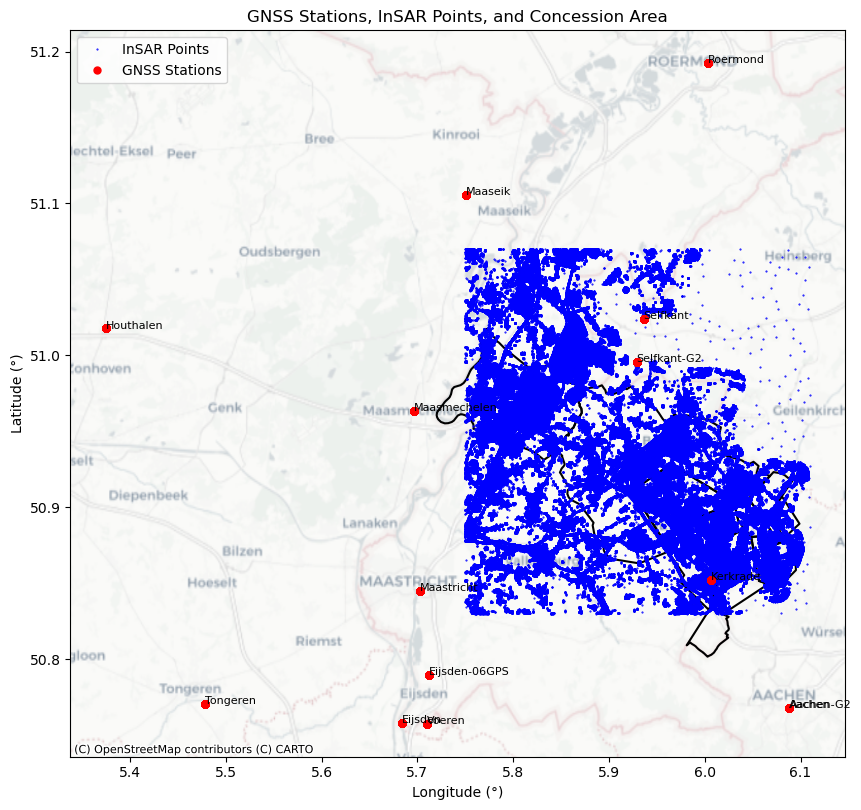

In [10]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
for name in df["pnt_name"].unique():
    subset = df[df["pnt_name"] == name]
    ax.text(
        subset["pnt_lon"].iloc[0],
        subset["pnt_lat"].iloc[0],
        name,
        fontsize=8,
        zorder=5
    )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

# station_name = "Kerkrade"
# buffer = 0.01

# st = df.loc[df["pnt_name"] == station_name].iloc[0]
# x0, y0 = st["pnt_lon"], st["pnt_lat"]

# xmin, xmax = x0 - buffer, x0 + buffer
# ymin, ymax = y0 - buffer, y0 + buffer

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


C:\Users\Nigel\AppData\Local\Temp\ipykernel_11288\385600993.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


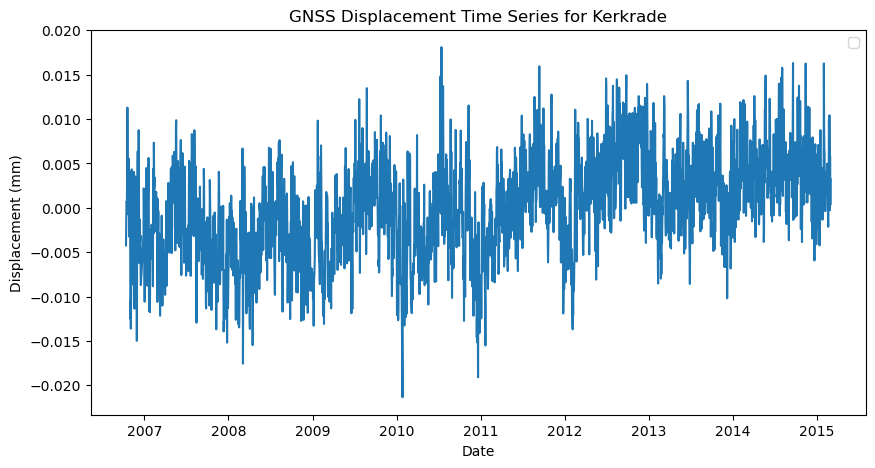

In [11]:
# Plot Kerkrade timeseries

station_name = "Kerkrade"
time_series = df[df["pnt_name"] == station_name].copy()

time_series = time_series.sort_values(by="dates")

plt.figure(figsize=(10, 5))
plt.plot(time_series["dates"], time_series["u"])
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS Displacement Time Series for {station_name}")
plt.legend()
plt.show()


